# Analyzing Medical Insurance Costs

---

## About the Dataset

The "[Medical Cost Personal Dataset](https://www.kaggle.com/datasets/mirichoi0218/insurance)" contains information on medical insurance costs for a sample of USA population.

The target variable is **charges**.

### Columns:
1. **age**: Age of the primary beneficiary
2. **sex**: Gender of the insurance contractor (female/male)
3. **bmi**: Body Mass Index, an objective index of body weight relative to height (kg/m²)
4. **children**: Number of children covered by health insurance / Number of dependents
5. **smoker**: Smoking status of the beneficiary
6. **region**: Beneficiary's residential area in the US (northeast, southeast, southwest, northwest)
7. **charges**: Individual medical costs billed by health insurance

---

## Data Cleaning

First we import the necessary libraries, then import the dataset and check its structure. After that, we proceed to cleaning it if necessary.

In [77]:
# data manipulation and analysis
import pandas as pd

# numerical operations
import numpy as np

# preprocessing tools
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# statistical functions and models
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# clustering algorithm
from sklearn.cluster import KMeans

# visualization libraries
import matplotlib.pyplot as plt # static data viz
import seaborn as sns           # advanced static data viz
import plotly.express as px     # interactive data viz

# database configuration
from config import HOSTNAME, USERNAME, PASSWORD, DATABASE, PORT
import psycopg2
from sqlalchemy import create_engine

In [78]:
# random seed
rseed = 42

In [79]:
# import the dataset
df = pd.read_csv('insurance.csv')

# check first rows
display(df.head())

# dataset description
print('\n## The dataset datatypes are:')
print(df.info())

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520



## The dataset datatypes are:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None


The data types are ready for use. We have categorical binary data that will be encoded: 'sex', 'smoker', 'region'.

In [80]:
# check missing values
print('## The dataset has', df.isna().sum().sum(), 'missing values.')

# check duplicates
print('\n## The dataset has', df.duplicated().sum(), 'duplicates.')

## The dataset has 0 missing values.

## The dataset has 1 duplicates.


No missing values, only one duplicate. Since there is no an 'ID' field and it is possible for two persons to have the same values, we'll keep that duplicate.

We proceed to overview the basic stats:

In [81]:
print(f'## The dataset stats are:\n: {df.describe()}')

## The dataset stats are:
:                age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010


A quick stats review:

- The average age is 39, with a std half that value we can expect some scattering. Also we can expect to see a right-skewed distribution given the min-max values from 18 to 64 (working-age).

- The average BMI ~ 30.66 falls in the category of obese. The values range from 15.96 (underweight) to 53.13 (severely obese). [For more info about BMI categories click here](https://en.wikipedia.org/wiki/Body_mass_index).

- The children number is 1.1 on average, with a std od 1.2 there is spreading expected.

- The charges start at 1121.87 to a max of 63770.43. A right-skewed distribution with the median significantly lower than the mean.

We take note on two details: a) obesity might be a concern of the population were the data was taken from, b) the ages falling in the working-age range suggests the dataset is employment-based.

Note: As we'll see below, this dataset follows an exponential distribution, rather than a normal distribution. **It is not appropriate to remove outliers at the outset by simply applying the Interquartile Range (IQR) method**.

# Exploratory Data Analysis

Encode categorical variables such as sex, smoker, and region to facilitate further analysis.

In [82]:
# check unique values in categorical columns
for col in ['sex', 'smoker', 'region']:
    print(f"\n## Unique values in {col}:")
    print(df[col].value_counts())


## Unique values in sex:
sex
male      676
female    662
Name: count, dtype: int64

## Unique values in smoker:
smoker
no     1064
yes     274
Name: count, dtype: int64

## Unique values in region:
region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64


In [83]:
# convert 'sex' and 'smoker' to binary
df['sex'] = df['sex'].map({'female': 0, 'male': 1})
df['smoker'] = df['smoker'].map({'no': 0, 'yes': 1})

# onehot encode region
df = pd.get_dummies(df, columns=['region'], prefix='region', dtype=int)

# chek it
display(df.head())

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


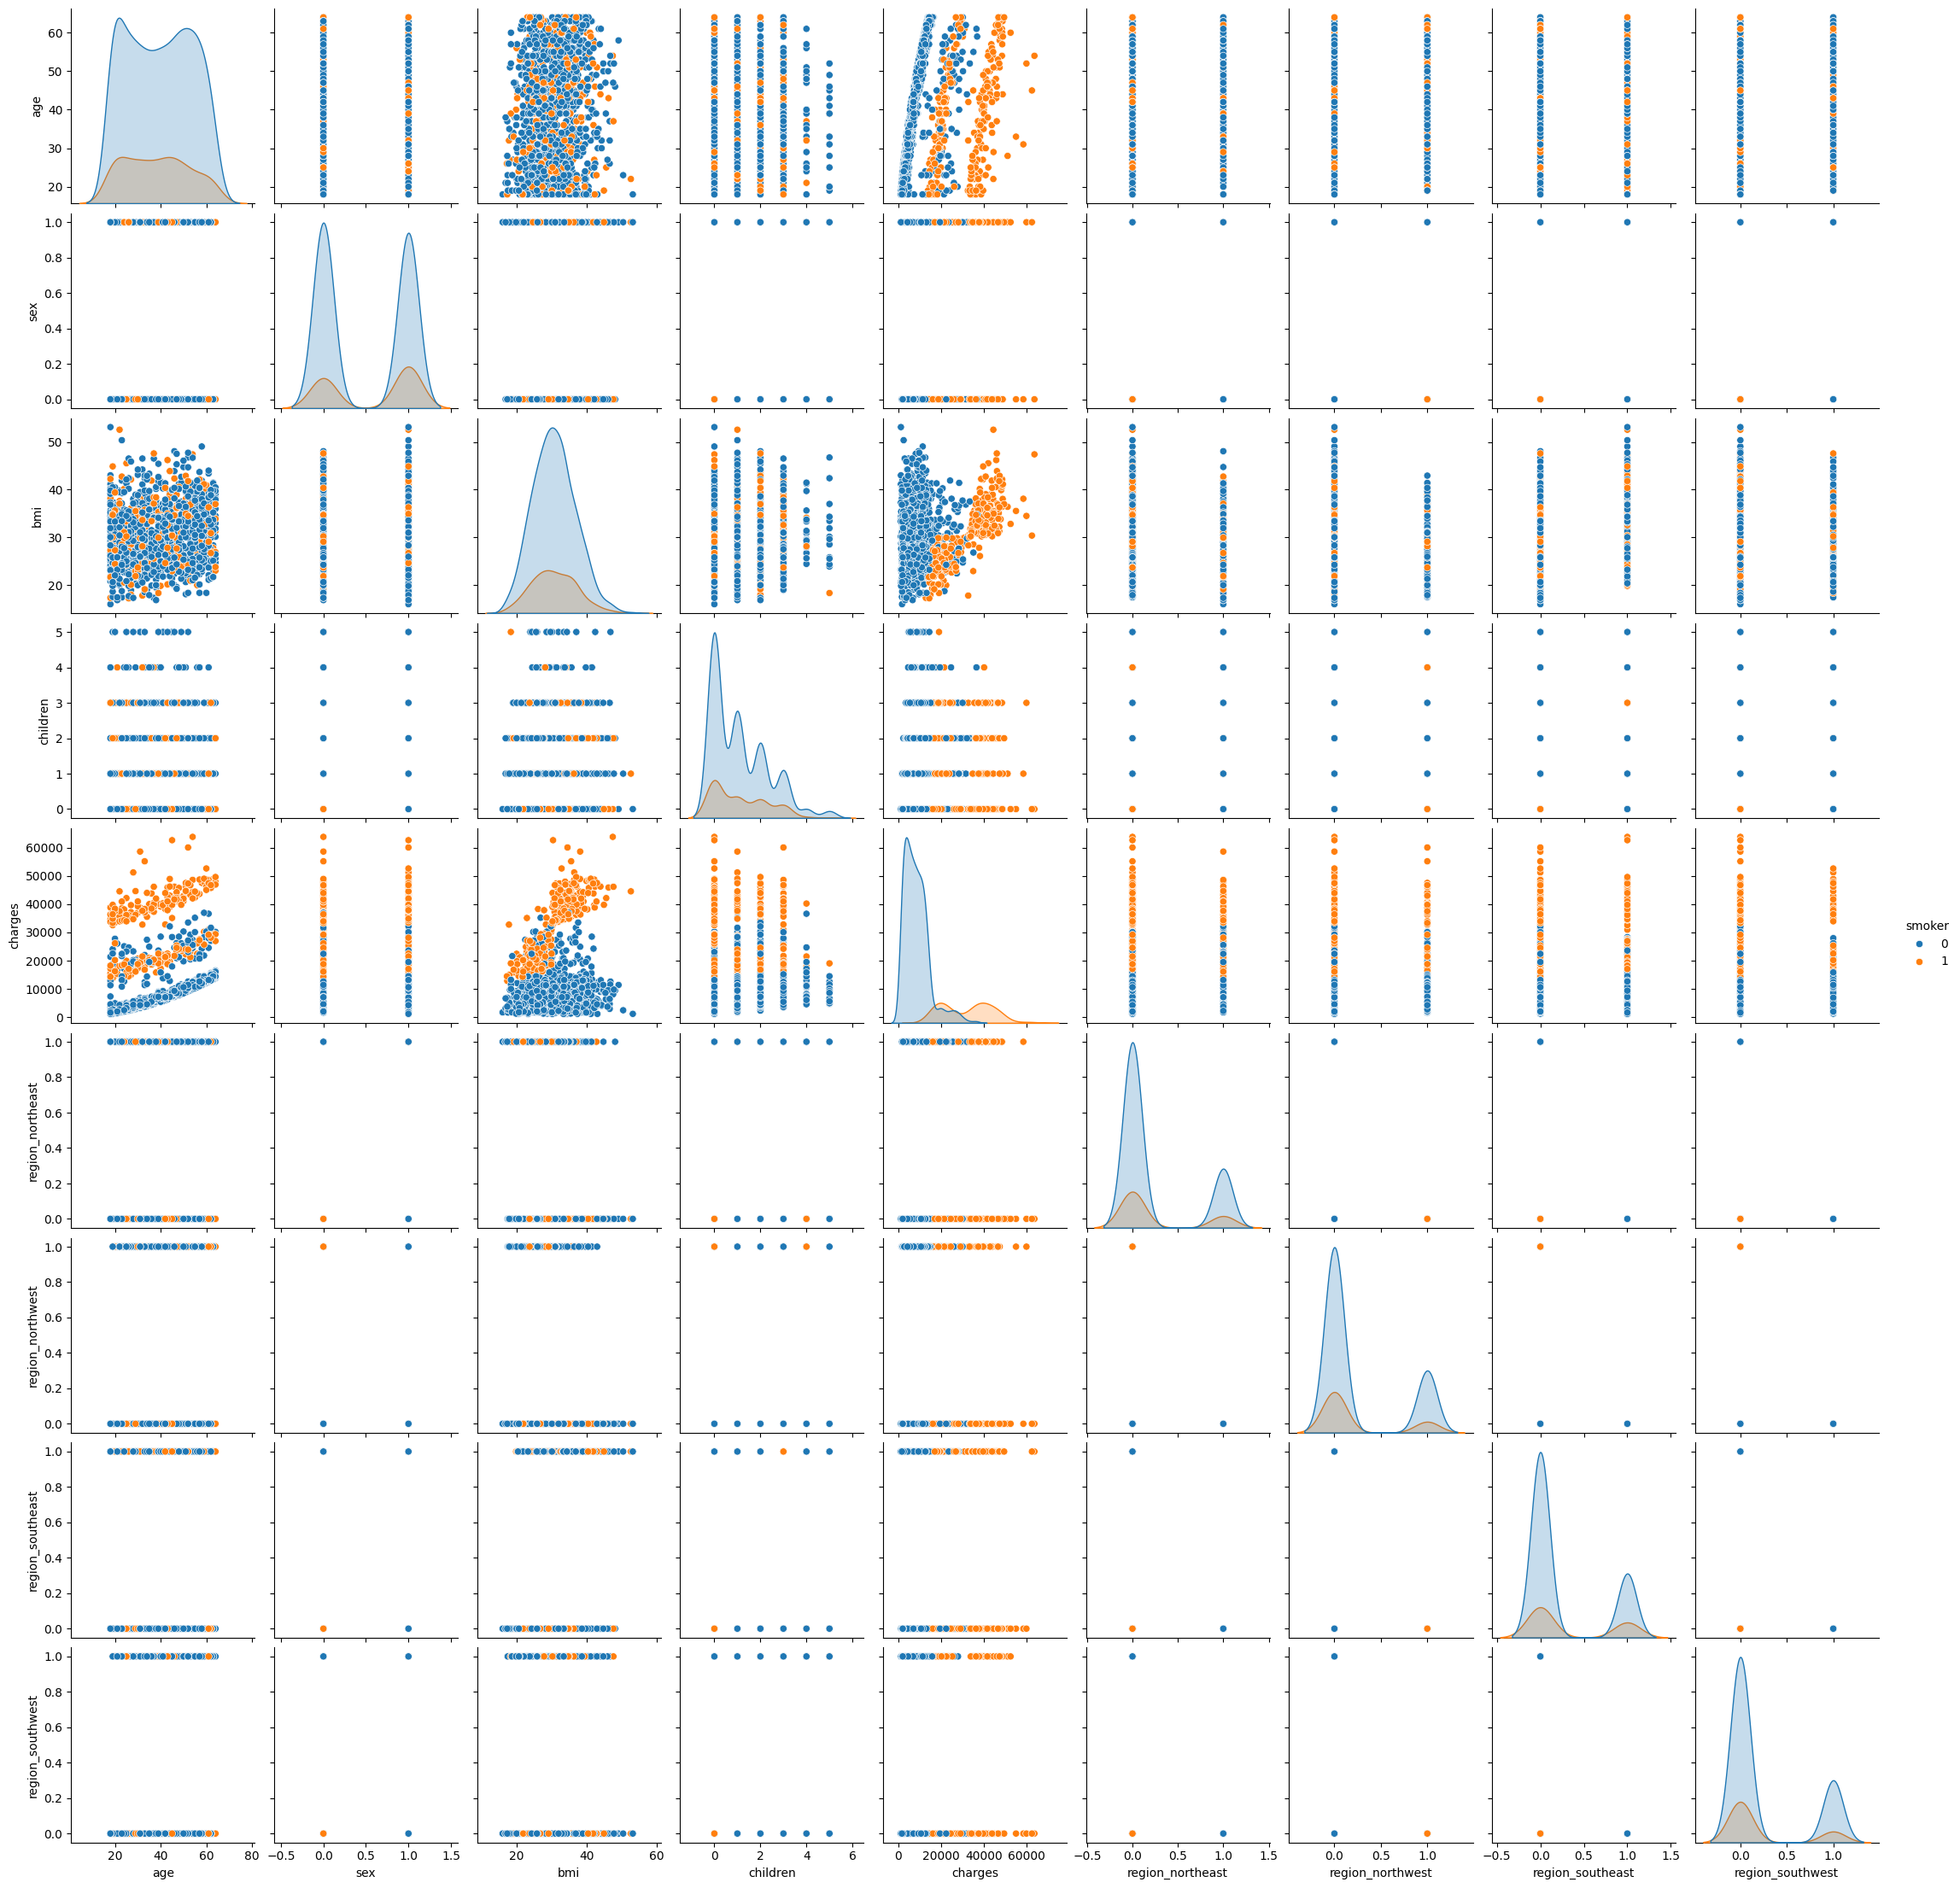

In [84]:
# outliers pairplot
sns.pairplot(df, hue='smoker')
plt.show()

The smoker ratio is about 1/5 of the total sample, there are a little more men than women that smoke. The smokers BMI is mainly below 30.

Our target variable 'charges' dependency on 'age' is exponential.

The 'charges' variable has three bands positively correlated with the 'age', the older the person the more the charges:

 - The lower and more populated band surely related to say a normal life conditions (no health risk), no smokers in this charges band.

 - The second band contains overcharges, contains smokers and some non smokers maybe with preexistent conditions.

 - The third and higher charges band has mainly smokers, surely people at health risk which also smoke. Additionally, smokers are automatically charged more once their BMI exceeds 30.

The Southweast region is the one with least smokers.

The 'age' distribution exhibits a minimum around 35 years and appears to be bimodal. This could be attributed to individuals around this age presenting lower risk, which may lead them to reconsider purchasing insurance due to the associated costs.

The 'charges' distribution for smokers is right displaced. Smokers are automatically charged an extra value.

Correlation Strength Table:

| Correlation Coefficient (r) | Strength of Relationship        |
|-----------------------------|----------------------------------|
| 0.90 to 1.00 or -0.90 to -1.00 | Very strong positive/negative correlation |
| 0.70 to 0.89 or -0.70 to -0.89 | Strong positive/negative correlation      |
| 0.40 to 0.69 or -0.40 to -0.69 | Moderate positive/negative correlation    |
| 0.10 to 0.39 or -0.10 to -0.39 | Weak positive/negative correlation        |
| 0.00 to 0.09 or -0.00 to -0.09 | No or negligible correlation              |

In the Pearson's correlation matrix we observe that, the target variable 'charges', shows a moderate correlation of +0.44 with age (as observed in the pairplot). It also exhibits a stronger correlation of +0.60 with 'smoker' status (as seen in the pairplot).

Sex and the number of children do not show significant correlations with any other variables.

The BMI demonstrates a few interesting correlations:

- A weak correlation of +0.12 with age (indicating that older individuals tend to have slightly higher BMI).
- A weak correlation of -0.26 with smoker status (suggesting that smokers tend to have lower BMI).
- Weak correlations ranging from -0.12 to -0.13 with northern regions (indicating that individuals in these regions tend to have slightly lower BMI).
- A weak correlation of +0.25 with the southeast region, which appears to have the highest prevalence of obesity.


## Feature Exploration: 'charges' variable



Explore the impact of different features on medical costs, focusing on key variables like BMI, smoking status, and the number of dependents.

In this section doesn't make much sense to isolate 'smoker' and 'bmi' variables, for we saw their relation with 'charges' is not immediate.

As we saw in the pairplots, the 'charges' vs 'age' presents three bands, with a possibly exponential growth each. We will try to cover those bands through feature ingeneering.

In [85]:
# new feature health risk groups
df['health_group'] = 'healthy'  # default group
df.loc[(df['smoker'] == 1) | (df['bmi'] >= 30), 'health_group'] = 'risk'
df.loc[(df['smoker'] == 1) & (df['bmi'] >= 30), 'health_group'] = 'combined risk'

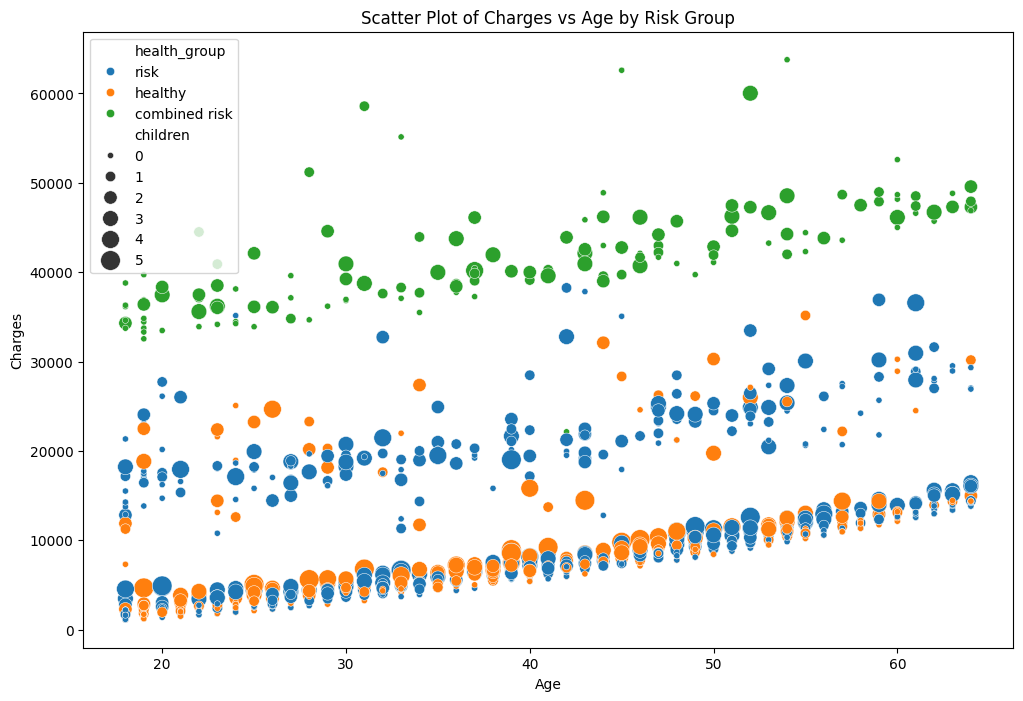

In [86]:
# create figure
plt.figure(figsize=(12, 8))

# scatter plot
sns.scatterplot(data=df, x='age', y='charges', hue='health_group', size='children', sizes=(20, 200))

# title labels
plt.title('Scatter Plot of Charges vs Age by Risk Group')
plt.xlabel('Age')
plt.ylabel('Charges')
plt.show()

In the scatter plot, to maintain the third band exclusively as a combination of smokers and another condition, we need to keep the threshold at BMI ≥ 30.

In the second band, we observe some cases of non-smokers with a BMI below 30. This may be due to other conditions such as asthma or diabetes, which are not documented in the dataframe.

Additionally, there are individuals with a BMI above 30 in the lower band. To keep this band relatively pure, a threshold of BMI ≥ 35 would be necessary. The last might indicate that although a high BMI has influence on how healthy a person is, it is not a determinant factor (as it is smoking).

We can also see the more the children, the more the charge on the healthy band. The base line, for people with lowest charge on the lower band, is composed of people without children. And we previously saw in the scatter plot that doesn't contain smokers. 

We proceed to analyze logarithmic dependencies

In [87]:
# create log-transformed columns for age and charges
df['log_age'] = np.log(df['age'])
df['log_charges'] = np.log(df['charges'])
df['log_children'] = np.log1p(df['children']) # log1p to handle zero values safely

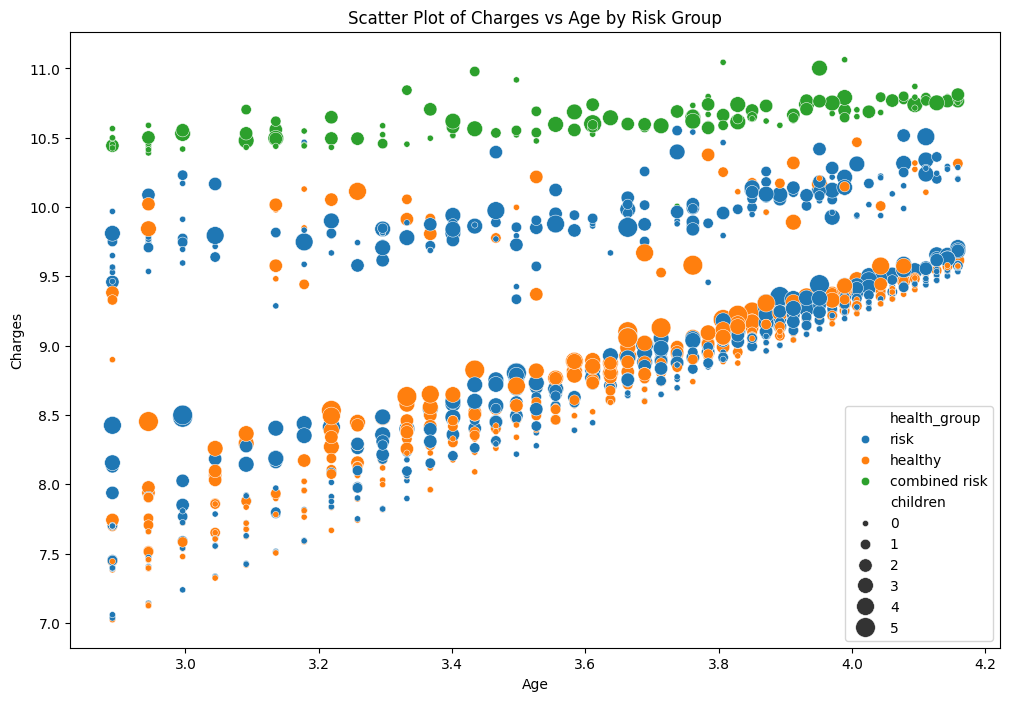

In [88]:
# create figure
plt.figure(figsize=(12, 8))

# scatter plot
sns.scatterplot(data=df, x='log_age', y='log_charges', hue='health_group', size='children', sizes=(20, 200))

# title labels
plt.title('Scatter Plot of Charges vs Age by Risk Group')
plt.xlabel('Age')
plt.ylabel('Charges')
plt.show()

The minimum values represent the base charges according to age for a completely healthy individual. Additional charges are then added to this base value. The base values exhibit exponential growth with age, suggesting that a logarithmic transformation could be beneficial.

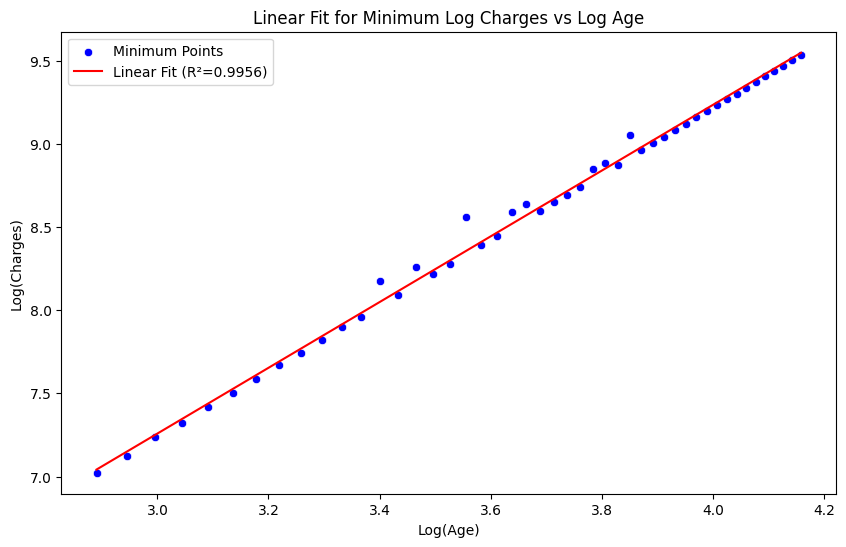

## Fit equation: log1p_charges = 1.9750 * log1p_age + 1.3333
## R^2: 0.9956


In [89]:
# find minimum log_charges for each log_age (fully healthy individuals, without children)
min_points = df[df['children'] == 0].groupby('log_age', as_index=False)['log_charges'].min()

# fit a linear regression model to the minimum points
X = min_points['log_age'].values.reshape(-1, 1)  # Predictor variable (reshaped for sklearn)
y = min_points['log_charges'].values  # Response variable

# define model
model = LinearRegression()
model.fit(X, y)

# get regression equation and R^2
slope = model.coef_[0]
intercept = model.intercept_
r_squared = r2_score(y, model.predict(X))

# plot scatter of minimum points and regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(x=min_points['log_age'], y=min_points['log_charges'], color='blue', label='Minimum Points')

# plot regression line
x_range = np.linspace(min_points['log_age'].min(), min_points['log_age'].max(), 100)
y_range = model.predict(x_range.reshape(-1, 1))
plt.plot(x_range, y_range, color='red', label=f'Linear Fit (R²={r_squared:.4f})')

# labels, title, and legend
plt.title('Linear Fit for Minimum Log Charges vs Log Age')
plt.xlabel('Log(Age)')
plt.ylabel('Log(Charges)')
plt.legend()
plt.show()

# print equation and R^2
print(f"## Fit equation: log1p_charges = {slope:.4f} * log1p_age + {intercept:.4f}")
print(f"## R^2: {r_squared:.4f}")

The fitted equation is:

$$
\log(\text{charges} + 1) = 2.0317 \cdot \log(\text{age} + 1) + 1.0677
$$

Therefore:

$$
\text{charges} = C_{1} \cdot (\text{age} + 1)^{2.0317} - 1
$$

where:

$$
C_{1} = e^{1.0677}
$$

And that is the base charge over which other charges will apply, specially if smoker.

In [90]:
# calculate C
C_CONSTANT = np.exp(1.0677)
print(C_CONSTANT)

2.9086818323973214


The base value represents only the minimum charge that companies use (still, now we know the equation they use!). For trend predictions instead, we observed in the "Scatter Plot of Charges vs. Age by Risk Group" that the lower band has an associated width; therefore, we will need to fit the scattered data. The same applies to the other bands.

Given the increase in charge for health group and number of children is constant, we can propose:

$$\text{charges} = C \cdot (\text{age} + 1)^{2.909} - 1 + C_{2}$$

with 

$$C_{2} = \text{children} \cdot c_{2}$$

Let us analize only the healthy group, but hueing by children:

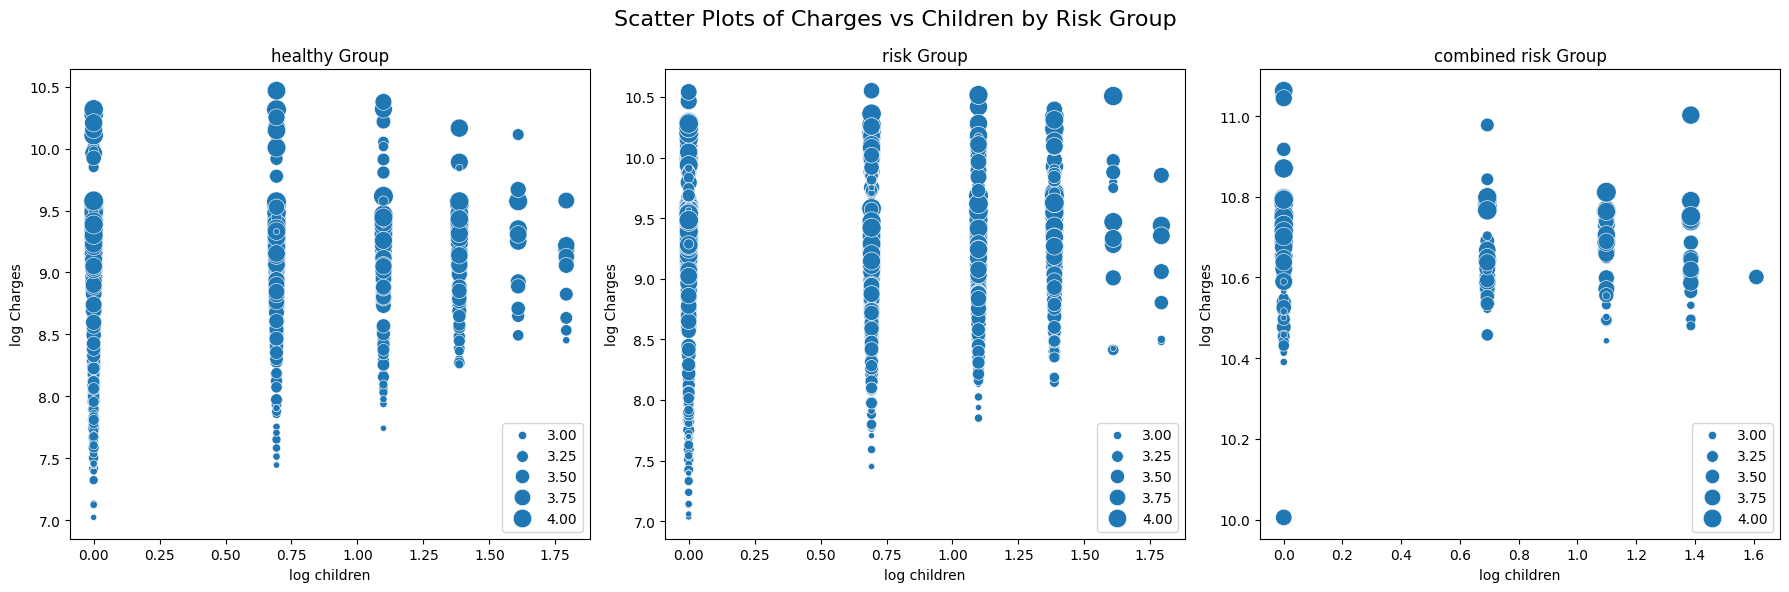

In [91]:
# Create figure with 3 subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# List of health groups and corresponding axes
health_groups = ['healthy', 'risk', 'combined risk']
axes = [ax1, ax2, ax3]

# Create a scatter plot for each health group
for ax, group in zip(axes, health_groups):
    sns.scatterplot(data=df[df['health_group'] == group], 
                    x='log_children', 
                    y='log_charges', 
                    # hue='sex',
                    size='log_age', 
                    sizes=(20, 200),
                    ax=ax)
    
    # Set title and labels for each subplot
    ax.set_title(f'{group} Group')
    ax.set_xlabel('log children')
    ax.set_ylabel('log Charges')
    ax.legend(loc='lower right')

# Set a main title for the entire figure
fig.suptitle('Scatter Plots of Charges vs Children by Risk Group', fontsize=16)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

We can observe that for the lower charges band ('healthy group') and for the middle band ('risk group'), there is a power law applied to the number of children, while the more expensive charges band ('combined risk group') is not affected by the number of children. The general equation would be:

$$
\text{charges}_{i} = B_{i} \cdot e^{a_{i} \cdot \text{age}} e^{b_{i} \cdot \text{children}^{n}} + k_{i}
$$

Where $i$ is the charges band, $B_{i}$ is the charges band proportionality constant, $b_{\text{combined risk}} = 0$, and $k_{i}$ is the y-intercept.

Solving that equation goes beyond the scope of this project, so we will **approximate** it by:

$$
\text{charges}_{i} \approx B_{i} \cdot e^{a_{i} \cdot \text{age}} + k_{i}
$$

In this way, the effect of the number of children will be absorbed into the general statistics of a simple linear fit on each log-transformed charges band:

$$
log(\text{charges}_{i}) \approx a_i \cdot log(\text{age}) + log(K_{i}) + error
$$

With $K_{i}$ a charges band associated constant and $error$ the statistical error.

Now we have two options:

- Work in the untransformed space with exponential fits, or
- Work in the log(x + 1) space with linear fits.

### Visual clustering and prediction

On the log1p space, the dataset can be divided by two lines. Then we flag the points for each cluster.

Note: It can be done in a more professional way by using KMeans, but given how well separated are the data we'll employ simply a visual method.

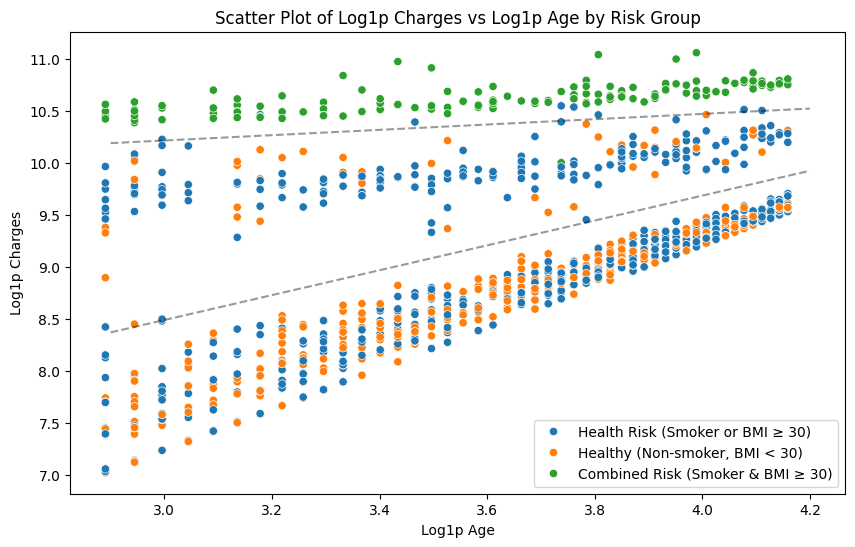

In [92]:
# scatter plot
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=df, x='log_age', y='log_charges', hue='health_group')

# get the current legend and update labels
handles, labels = scatter.get_legend_handles_labels()
custom_labels = [
    "Health Risk (Smoker or BMI ≥ 30)", # for some reason need to reverse them
    "Healthy (Non-smoker, BMI < 30)", # for some reason need to reverse them
    "Combined Risk (Smoker & BMI ≥ 30)"
    ]
# plt.legend(handles=handles, labels=custom_labels, title="Health Risk Group")
plt.legend(handles=handles, labels=custom_labels)

# line 1: y = m1 * x + c1
m1 = (10.50729 - 10.2301) / (4.127134 - 3.044522) # slope
c1 = 10.2301 - m1 * 3.044522 # intercept
x1 = np.linspace(2.9, 4.2, 100) # generate x values
y1 = m1 * x1 + c1 # calculate y values
plt.plot(x1, y1, color='k', linestyle='--', alpha= 0.4)

# line 2: y = m2 * x + c2
m2 = (9.457061 - 8.425558) / (3.806662 - 2.944439) # slope
c2 = 9.457061 - m2 * 3.806662 # intercept
x2 = np.linspace(2.9, 4.2, 100) # generate x values
y2 = m2 * x2 + c2 # calculate y values
plt.plot(x2, y2, color='k', linestyle='--', alpha= 0.4)

# title & labels
plt.title('Scatter Plot of Log1p Charges vs Log1p Age by Risk Group')
plt.xlabel('Log1p Age')
plt.ylabel('Log1p Charges')

# release the kraken
plt.show()


# # -------------------------------------------------------------------------
# calculate y-values for line1 and line2 based on log_age
df['line1'] = m1 * df['log_age'] + c1
df['line2'] = m2 * df['log_age'] + c2

# assign clusters based on conditions:
# 0 if below line2, 2 if above line1, 1 otherwise
df['cluster'] = np.where(df['log_charges'] < df['line2'], 0,
                         np.where(df['log_charges'] > df['line1'], 2, 1))

# remove the temporary columns
df.drop(columns=['line1', 'line2'], inplace=True)

 As we observed from the beginning, the Interquartile Range (IQR) method is not suitable for outlier removal in this context. Instead, we should calculate the trend line for each cluster and then analyze the residuals to identify and handle outliers.

R^2 score for Trend 1: 0.4397
R^2 score for Trend 0: 0.9422
R^2 score for Trend 2: 0.4859


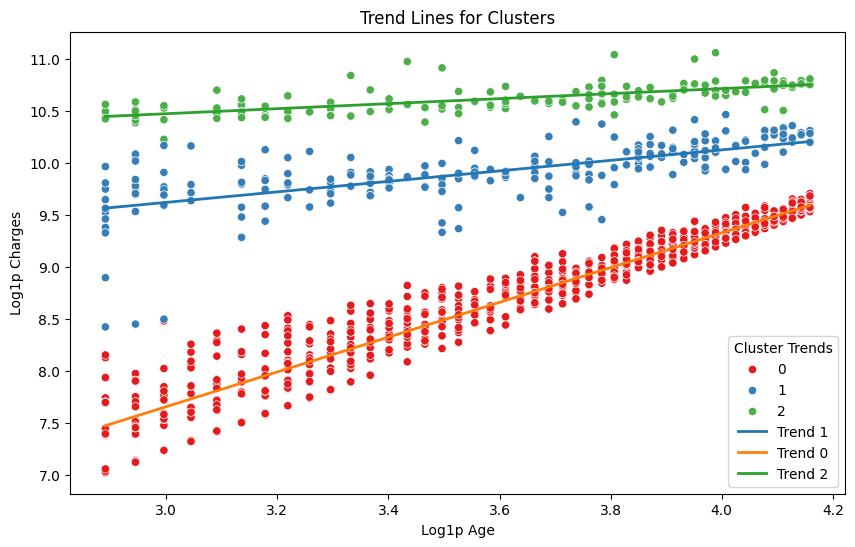

Trend trend1: y = 0.5050 * x + 8.1085
Trend trend0: y = 1.6720 * x + 2.6423
Trend trend2: y = 0.2415 * x + 9.7519


In [93]:
# initialize a dictionary to store trend line parameters
trends = {}

# scatter plot of all clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='log_age', y='log_charges', hue='cluster', palette='Set1')

# loop through each cluster to calculate trend lines
for cluster in df['cluster'].unique():
    # filter data for the current cluster
    cluster_data = df[df['cluster'] == cluster]

    # define X and y for regression
    X = cluster_data[['log_age']]  # must be 2D for sklearn
    y = cluster_data['log_charges']

    # fit linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # store slope m and intercept c
    trends[f'trend{cluster}'] = {'slope': model.coef_[0], 'intercept': model.intercept_}

    # calculate R^2 score for the current cluster
    r2 = r2_score(y, model.predict(X))
    print(f"R^2 score for Trend {cluster}: {r2:.4f}")

    # generate x values for plotting the trend line
    x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    x_range = pd.DataFrame(x_range, columns=X.columns) # feature names
    y_pred = model.predict(x_range)

    # plot the trend line
    plt.plot(x_range, y_pred, label=f'Trend {cluster}', linewidth=2)

# title and labels
plt.title('Trend Lines for Clusters')
plt.xlabel('Log1p Age')
plt.ylabel('Log1p Charges')
plt.legend(title='Cluster Trends')
plt.show()

# print trend line equations for each cluster
for cluster, params in trends.items():
    print(f"Trend {cluster}: y = {params['slope']:.4f} * x + {params['intercept']:.4f}")

Flag outliers using residual analysis (the residuals are the vertical distances between the actual log_charges values and the predicted values from the trend lines):

In [94]:
# start all points as non-outliers (inliers)
df['outlier'] = False

for cluster in df['cluster'].unique():
    # filter data by cluster
    cluster_data = df[df['cluster'] == cluster]

    # get slope and intercept of the trend line for this cluster
    slope = trends[f'trend{cluster}']['slope']
    intercept = trends[f'trend{cluster}']['intercept']

    # calculate predicted values using the trend line
    predicted = slope * cluster_data['log_age'] + intercept

    # calculate residuals
    residuals = cluster_data['log_charges'] - predicted

    # define threshold for outliers (e.g., 2 standard deviations)
    threshold = 2 * residuals.std()

    # flag points as outliers if residual exceeds threshold
    is_outlier = abs(residuals) > threshold
    df.loc[cluster_data.index, 'outlier'] = is_outlier

# check
print(f"## Number of outliers: {df['outlier'].sum()}, inliers: {len(df[df['outlier'] == False])}")

## Number of outliers: 104, inliers: 1234


R^2 score for Trend 1: 0.5881
R^2 score for Trend 0: 0.9683
R^2 score for Trend 2: 0.7222


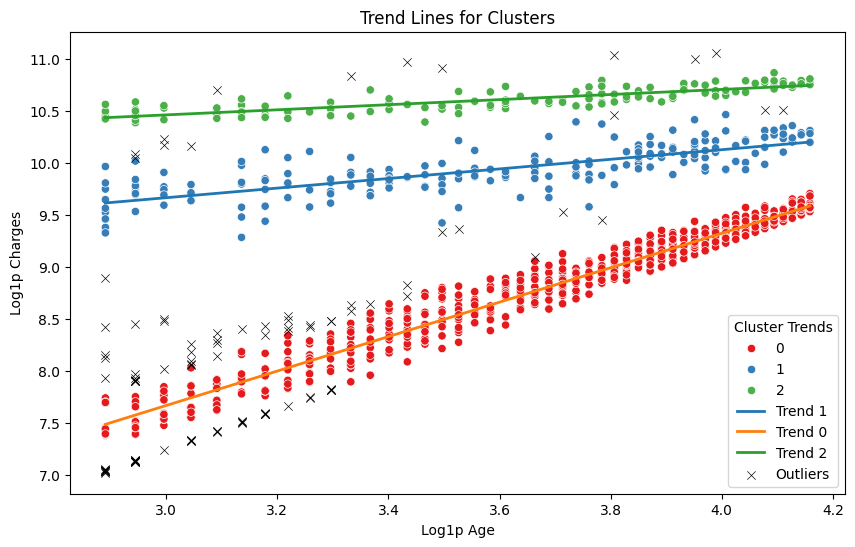

Trend trend1: y = 0.4618 * x + 8.2830
Trend trend0: y = 1.6563 * x + 2.7008
Trend trend2: y = 0.2448 * x + 9.7307


In [95]:
# initialize a dictionary to store trend line parameters
trends = {}

# filter by flag
df_inliers = df[df['outlier'] == False]
df_outliers = df[df['outlier'] == True]

# scatter plot of all clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_inliers, x='log_age', y='log_charges', hue='cluster', palette='Set1')

# loop through each cluster to calculate trend lines
for cluster in df_inliers['cluster'].unique():
    # filter data for the current cluster
    cluster_data = df_inliers[df_inliers['cluster'] == cluster]

    # define X and y for regression
    X = cluster_data[['log_age']]  # must be 2D for sklearn
    y = cluster_data['log_charges']

    # fit linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # store slope (m) and intercept (c)
    trends[f'trend{cluster}'] = {'slope': model.coef_[0], 'intercept': model.intercept_}

    # calculate R^2 score for the current cluster
    r2 = r2_score(y, model.predict(X))
    print(f"R^2 score for Trend {cluster}: {r2:.4f}")

    # generate x values for plotting the trend line
    x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    x_range = pd.DataFrame(x_range, columns=X.columns) # feature names
    y_pred = model.predict(x_range)

    # plot the trend line
    plt.plot(x_range, y_pred, label=f'Trend {cluster}', linewidth=2)

# plot outliers
sns.scatterplot(data=df_outliers, x='log_age', y='log_charges', color='k', label='Outliers', marker='x')

# title and labels
plt.title('Trend Lines for Clusters')
plt.xlabel('Log1p Age')
plt.ylabel('Log1p Charges')
plt.legend(title='Cluster Trends')
plt.show()

# print trend line equations for each cluster
for cluster, params in trends.items():
    print(f"Trend {cluster}: y = {params['slope']:.4f} * x + {params['intercept']:.4f}")

REDO!!!!!!!

Now we check normality for each cluster:

In [96]:
# calculate error
df['error'] = 0.

for cluster in df['cluster'].unique():
    # filter data by cluster
    cluster_data = df[df['cluster'] == cluster]

    # get slope and intercept of the trend line for this cluster
    slope = trends[f'trend{cluster}']['slope']
    intercept = trends[f'trend{cluster}']['intercept']

    # calculate predicted values using the trend line
    predicted = slope * cluster_data['log_age'] + intercept

    # calculate residuals
    residuals = cluster_data['log_charges'] - predicted

    # update error column with residuals
    df.loc[cluster_data.index, 'error'] = residuals

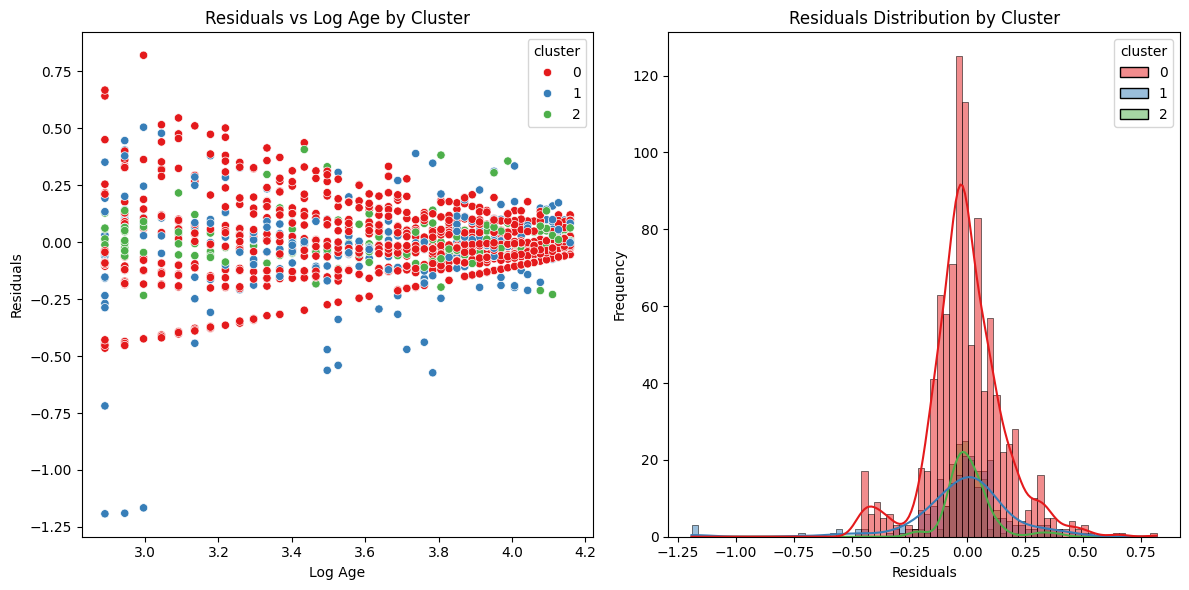

In [97]:
# plot residuals scatter and histogram by cluster
plt.figure(figsize=(12, 6))

# scatter plot
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='log_age', y='error', hue='cluster', palette='Set1')
plt.title('Residuals vs Log Age by Cluster')
plt.xlabel('Log Age')
plt.ylabel('Residuals')

# histogram
plt.subplot(1, 2, 2)
sns.histplot(data=df, x='error', hue='cluster', palette='Set1', kde=True)
plt.title('Residuals Distribution by Cluster')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# adjust layout
plt.tight_layout()
plt.show()

All three clusters exhibit negative kurtosis, indicating that they do not follow a normal distribution. Therefore, a t-test should not be used for comparison. It is left as an exercise for the reader to compare the cluster distributions using non-parametric methods.

Finally we can check the inverse transform of the trend lines on the dataset.

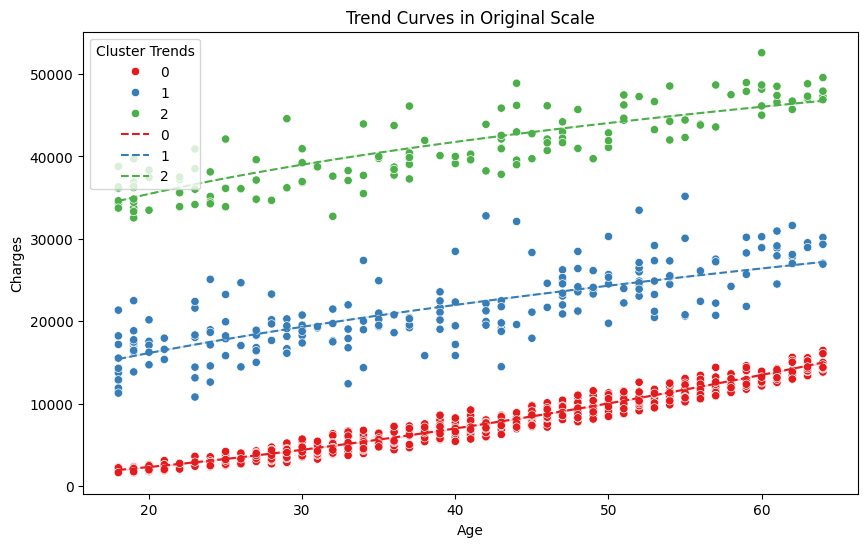

In [98]:
df_inliers = df_inliers.copy()

# calculate predictions for each cluster and store them in df_inliers['prediction']
for cluster in df_inliers['cluster'].unique():
    # filter data for the current cluster
    cluster_data = df_inliers[df_inliers['cluster'] == cluster]

    # extract slope and intercept from trends
    slope_log = trends[f'trend{cluster}']['slope']
    intercept_log = trends[f'trend{cluster}']['intercept']

    # calculate predictions in the log-transformed space
    prediction_log = slope_log * np.log1p(cluster_data['age']) + intercept_log

    # inverse transform predictions back to the original scale
    prediction_original = np.exp(prediction_log) - 1  # inverse of log1p

    # assign predictions to df_inliers
    df_inliers.loc[cluster_data.index, 'prediction'] = prediction_original

# plot it
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_inliers, x='age', y='charges', hue='cluster', palette='Set1')
sns.lineplot(data=df_inliers, x='age', y='prediction', hue='cluster', palette='Set1', linestyle='--')
plt.title('Trend Curves in Original Scale')
plt.xlabel('Age')
plt.ylabel('Charges')
plt.legend(title='Cluster Trends')
plt.show()

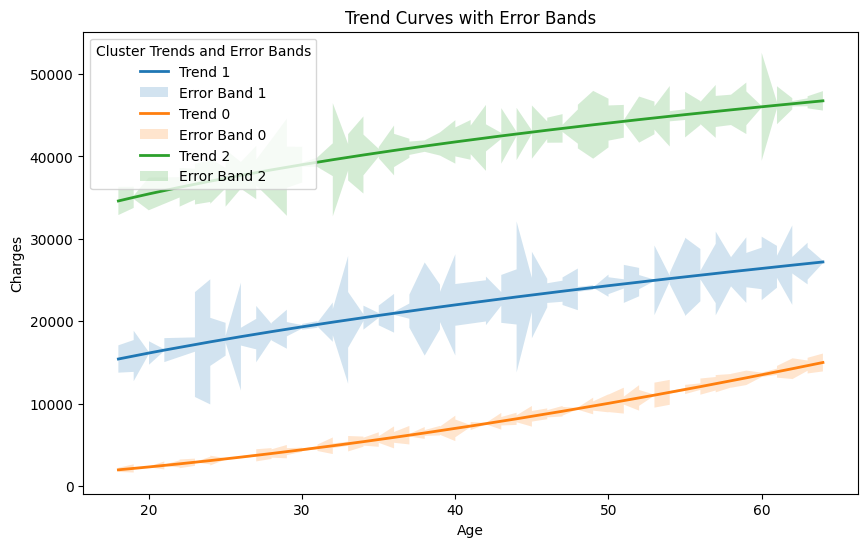

In [99]:
# calculate the error as the absolute difference between charges and predictions
df_inliers['error'] = np.abs(df_inliers['charges'] - df_inliers['prediction'])

# plot trend lines with error bands
plt.figure(figsize=(10, 6))

# loop through each cluster to plot trend lines and error bands
for cluster in df_inliers['cluster'].unique():
    # filter data for the current cluster
    cluster_data = df_inliers[df_inliers['cluster'] == cluster]

    # sort data by age for smooth plotting
    cluster_data = cluster_data.sort_values(by='age')

    # plot the trend line (predictions)
    plt.plot(cluster_data['age'], cluster_data['prediction'], label=f'Trend {cluster}', linewidth=2)

    # plot the error band as a shaded region
    plt.fill_between(
        cluster_data['age'],
        cluster_data['prediction'] - cluster_data['error'],  # lower bound of error band
        cluster_data['prediction'] + cluster_data['error'],  # upper bound of error band
        alpha=0.2, label=f'Error Band {cluster}'
    )

# title and labels
plt.title('Trend Curves with Error Bands')
plt.xlabel('Age')
plt.ylabel('Charges')
plt.legend(title='Cluster Trends and Error Bands')
plt.show()

In [100]:
# calculate the MAE and RMSE by cluster
mae = df_inliers.groupby('cluster')['error'].mean()
rmse = np.sqrt(df_inliers.groupby('cluster')['error'].apply(lambda x: np.mean(x**2)))

# print the results
print("\n## Mean Absolute Error by Cluster:")
print(mae)
print("\n## Root Mean Squared Error by Cluster:")
print(rmse)


## Mean Absolute Error by Cluster:
cluster
0     616.486986
1    2311.668631
2    2006.350260
Name: error, dtype: float64

## Root Mean Squared Error by Cluster:
cluster
0     745.840478
1    3088.499083
2    2451.401818
Name: error, dtype: float64


The fit is very good for the lower charges band. For the upper bands, due the dispersion, the fit is not great not terrible. It shows how variable are the extra charges given by insurance companies for any category they consider with health risk.

 Now we homogenize the data. Based on BMI and smoking factors, we observed three distinct charge bands. The dataset was separated into three clusters where individual prediction curves were calculated.

 Although the three bands are well defined by category, some points that should fall into one defined category cluster belong to a different cluster. This is likely due to other health conditions not included in the dataset, such as asthma and diabetes. To address this issue and homogenize the data, we designate cluster 0 to correspond to the 'healthy' group, cluster 1 to the 'risk' group, and cluster 2 to the 'combined risk' group.

In [101]:
# we calculate the category probability of falling in determined cluster
prob_healthy = len(df_inliers[(df_inliers['cluster'] == 0) & (df_inliers['health_group'] == 'healthy')]) / len(df_inliers[df_inliers['health_group'] == 'healthy'])
print(f"## Probability of being healthy in cluster 0: {prob_healthy:.4f}")
prob_risk = len(df_inliers[(df_inliers['cluster'] == 1) & (df_inliers['health_group'] == 'risk')]) / len(df_inliers[df_inliers['health_group'] == 'risk'])
print(f"## Probability of being risk in cluster 1: {prob_risk:.4f}")
prob_combined_risk = len(df_inliers[(df_inliers['cluster'] == 2) & (df_inliers['health_group'] == 'combined risk')]) / len(df_inliers[df_inliers['health_group'] == 'combined risk'])
print(f"## Probability of being combined risk in cluster 2: {prob_combined_risk:.4f}")

## Probability of being healthy in cluster 0: 0.9111
## Probability of being risk in cluster 1: 0.2677
## Probability of being combined risk in cluster 2: 0.9928


There are many non smokers with BMI > 30 on the healthy group. Only the BMI alone is not enough for the intermediate risk band, or the health risk factor is not enough for clustering.

### KMeans (ML clustering)

Given the only BMI and smoking factor in the healthy risk caracterization are not enough, , we'll now perform K-means clustering to identify potential patterns or groupings in our dataset.

In [109]:
df

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest,health_group,log_age,log_charges,log_children,cluster,outlier,error
0,19,0,27.900,0,1,16884.92400,0,0,0,1,risk,2.944439,9.734176,0.000000,1,False,0.091498
1,18,1,33.770,1,0,1725.55230,0,0,1,0,risk,2.890372,7.453302,0.693147,0,False,-0.034801
2,28,1,33.000,3,0,4449.46200,0,0,1,0,risk,3.332205,8.400538,1.386294,0,False,0.180635
3,33,1,22.705,0,0,21984.47061,0,1,0,0,healthy,3.496508,9.998092,0.000000,1,False,0.100489
4,32,1,28.880,0,0,3866.85520,0,1,0,0,healthy,3.465736,8.260197,0.000000,0,False,-0.180872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,10600.54830,0,1,0,0,risk,3.912023,9.268661,1.386294,0,False,0.088415
1334,18,0,31.920,0,0,2205.98080,1,0,0,0,risk,2.890372,7.698927,0.000000,0,False,0.210824
1335,18,0,36.850,0,0,1629.83350,0,0,1,0,risk,2.890372,7.396233,0.000000,0,False,-0.091870
1336,21,0,25.800,0,0,2007.94500,0,0,0,1,healthy,3.044522,7.604867,0.000000,0,False,-0.138553


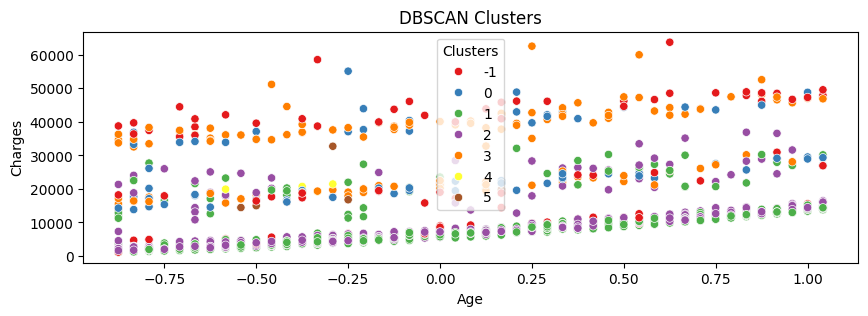

In [254]:
# import dbscan
from sklearn.cluster import DBSCAN

# Define columns to copy
cols = ['age', 'sex', 'bmi', 'children', 'smoker', 'charges']

# Make a new df
df_model = df[cols].copy()

# Get dummies for health_group
# df_model = pd.get_dummies(df_model, columns=['health_group'], prefix='health', drop_first=False, dtype=int)

# Separate features and target
features = df_model.drop('charges', axis=1)
target = df_model['charges']

# Scale the features
scaler = RobustScaler()
scaled_features = scaler.fit_transform(features)

# Convert scaled features back to dataframe with original column names
df_scaled = pd.DataFrame(scaled_features, columns=features.columns)

# Add back the target variable
df_scaled['charges'] = target

# Define the model
# model = DBSCAN(eps=.5, min_samples=3)
model = DBSCAN(eps=.52, min_samples=7)

# Fit the model (excluding 'charges' column)
clusters = model.fit_predict(df_scaled.drop('charges', axis=1)).copy()

# Add cluster labels to the dataframe
df_scaled['cluster'] = clusters

# print(df_scaled.head())
# print(f"Number of clusters: {len(set(clusters))}")

# plot the clusters
plt.figure(figsize=(10, 3))
sns.scatterplot(data=df_scaled, x='age', y='charges', hue='cluster', palette='Set1')
plt.title('DBSCAN Clusters')
plt.xlabel('Age')
plt.ylabel('Charges')
plt.legend(title='Clusters')
plt.show()

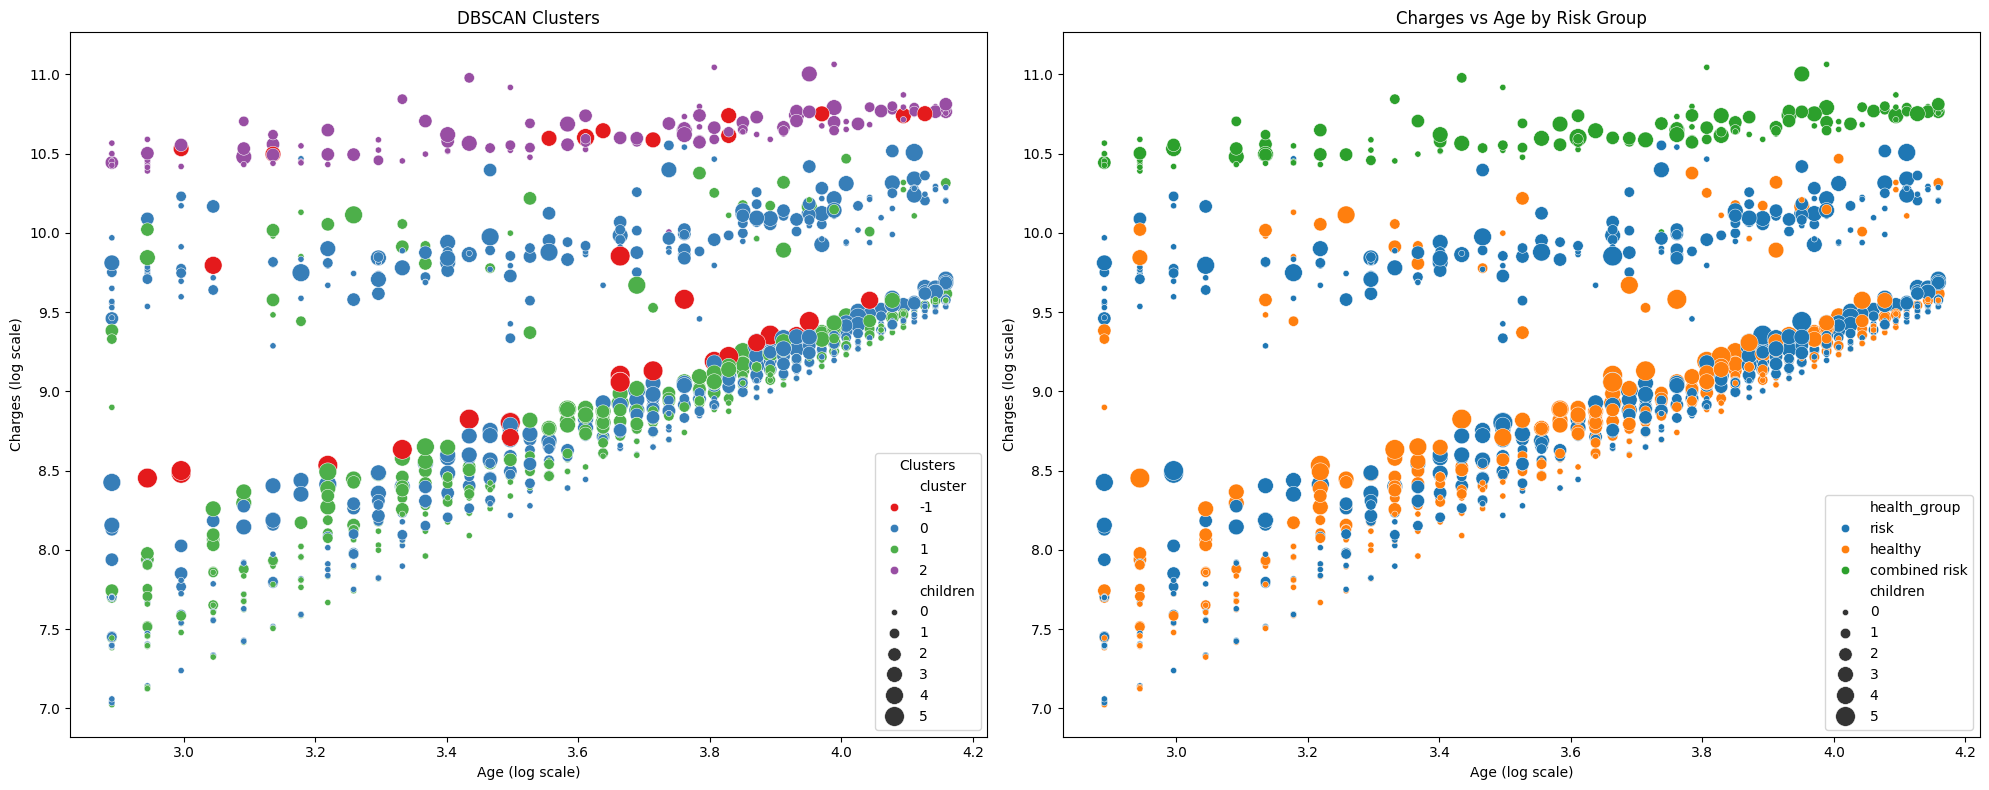

In [281]:
# import dbscan
from sklearn.cluster import DBSCAN

# Define columns to copy
cols = ['age', 'children', 'health_group', 'charges']

# Make a new df
df_model = df[cols].copy()

# Get dummies for health_group
df_model = pd.get_dummies(df_model, columns=['health_group'], prefix='health', drop_first=False, dtype=int)

# Separate features and target
features = df_model.drop('charges', axis=1)
target = df_model['charges']

# Scale the features
scaler = RobustScaler()
scaled_features = scaler.fit_transform(features)

# Convert scaled features back to dataframe with original column names
df_scaled = pd.DataFrame(scaled_features, columns=features.columns)

# Add back the target variable
df_scaled['charges'] = target

# Define the model
# model = DBSCAN(eps=.5, min_samples=3)
model = DBSCAN(eps=.5, min_samples=15)

# Fit the model (excluding 'charges' column)
clusters = model.fit_predict(df_scaled.drop('charges', axis=1)).copy()

# Add cluster labels to the dataframe
df['cluster'] = clusters

# print(df_scaled.head())
# print(f"Number of clusters: {len(set(clusters))}")

# # plot the clusters
# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=df, x='log_age', y='log_charges', hue='cluster', palette='Set1', size='children', sizes=(20, 200))
# plt.title('DBSCAN Clusters')
# plt.xlabel('Age')
# plt.ylabel('Charges')
# plt.legend(title='Clusters')
# plt.show()

# # create figure
# plt.figure(figsize=(10, 6))

# # scatter plot
# sns.scatterplot(data=df, x='log_age', y='log_charges', hue='health_group', size='children', sizes=(20, 200))

# # title labels
# plt.title('Scatter Plot of Charges vs Age by Risk Group')
# plt.xlabel('Age')
# plt.ylabel('Charges')
# plt.show()

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: DBSCAN Clusters
sns.scatterplot(data=df, x='log_age', y='log_charges', hue='cluster', 
                palette='Set1', size='children', sizes=(20, 200), ax=ax1)
ax1.set_title('DBSCAN Clusters')
ax1.set_xlabel('Age (log scale)')
ax1.set_ylabel('Charges (log scale)')
ax1.legend(title='Clusters')

# Plot 2: Scatter Plot by Risk Group
sns.scatterplot(data=df, x='log_age', y='log_charges', hue='health_group', 
                size='children', sizes=(20, 200), ax=ax2)
ax2.set_title('Charges vs Age by Risk Group')
ax2.set_xlabel('Age (log scale)')
ax2.set_ylabel('Charges (log scale)')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

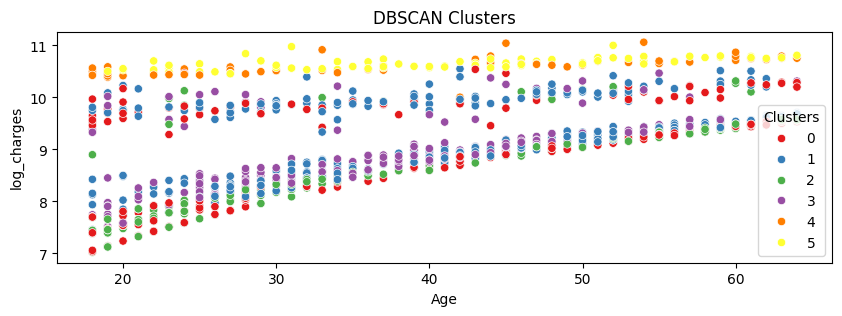

In [272]:
# import dbscan
from sklearn.cluster import DBSCAN

# Define columns to copy
cols = ['age', 'log_children', 'health_group', 'log_charges']

# Make a new df
df_model = df[cols].copy()

# Get dummies for health_group
df_model = pd.get_dummies(df_model, columns=['health_group'], prefix='health', drop_first=False, dtype=int)

# Separate features and target
features = df_model.drop('log_charges', axis=1)
target = df_model['log_charges']

# Scale the features
scaler = RobustScaler()
scaled_features = scaler.fit_transform(features)

# Convert scaled features back to dataframe with original column names
df_scaled = pd.DataFrame(scaled_features, columns=features.columns)

# Add back the target variable
df_scaled['log_charges'] = target

# Define the model
# model = DBSCAN(eps=.5, min_samples=3)
model = DBSCAN(eps=.4, min_samples=3)

# Fit the model (excluding 'log_charges' column)
clusters = model.fit_predict(df_scaled.drop('log_charges', axis=1)).copy()

# Add cluster labels to the dataframe
df['cluster'] = clusters

# print(df_scaled.head())
# print(f"Number of clusters: {len(set(clusters))}")

# plot the clusters
plt.figure(figsize=(10, 3))
sns.scatterplot(data=df, x='age', y='log_charges', hue='cluster', palette='Set1')
plt.title('DBSCAN Clusters')
plt.xlabel('Age')
plt.ylabel('log_charges')
plt.legend(title='Clusters')
plt.show()

KMeans alone is not sufficient to cluster the groups in the observed bands. It is left as an exercise for the reader to define the initial centroids at the center of each band.

### Regional Analysis

Now we analysize how medical costs vary by region

In [257]:
cols_to_plot = ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges', 'cluster']

sns.pairplot(df_inliers[cols_to_plot], hue='region')
plt.show()

KeyError: "['region'] not in index"

In the pairplot, we observe that the distribution of charges is bimodal due to the three charge bands. But separating by charges cluster we get a better view.

The region with the lowest charges agglomeration is Northwest, followed closely by Southwest; the region with the highest peak of charges is Southeast.

This observation is likely due to the fact that when we examine the distributions of the 'smoker' and 'bmi' features, they correlate with 'charges' by region.

In [25]:
# we group by region and agg the data
df_region_agg = df_inliers.groupby('region').agg({
    'age': ['mean'],
    'bmi': ['mean'],
    'children': ['mean'],
    'charges': ['mean'],
    'smoker': ['sum']
})

# make it readable
df_region_agg.columns = ['_'.join(col).strip() for col in df_region_agg.columns.values]
df_region_agg = df_region_agg.reset_index()
display(df_region_agg)

KeyError: 'region'

In [29]:
# df_region_agg['region'].unique()

region_to_states = {
    'northeast': ['ME', 'NH', 'VT', 'MA', 'RI', 'CT', 'NY', 'NJ', 'PA'],
    'northwest': ['WA', 'OR', 'ID', 'MT', 'WY'],
    'southeast': ['VA', 'WV', 'KY', 'TN', 'NC', 'SC', 'GA', 'AL',
                  'MS', 'FL'],
    'southwest': ['AZ', 'NM', 'TX', 'OK'],
}

# Flatten the mapping into a DataFrame
region_state_map = []
for region, states in region_to_states.items():
    for state in states:
        region_state_map.append({'region': region, 'state': state})

region_state_df = pd.DataFrame(region_state_map)

# Merge with the original data
df_expanded = region_state_df.merge(df_region_agg, on='region', how='left')

In [26]:
# plot a usa map by state
p = px.choropleth(
    df_expanded,
    locations='state',  # use state abbreviations
    locationmode='USA-states',
    color='charges_mean',  # metric to visualize
    hover_name='region',  # region name on hover
    hover_data={
        'charges_mean': True,
        'age_mean': True,
        'bmi_mean': True,
        'children_mean': True,
        'smoker_sum': True,
    },
    color_continuous_scale='Viridis',  # color scale
    title='Average Charges by Region in USA'
)

# update layout for size and focus
p.update_layout(
    geo=dict(scope='usa'),
    autosize=False,
    width=1200,
    height=600,
    title_x=0.5  # center the title
)

# release the kraken
p.show()

NameError: name 'df_expanded' is not defined

### Backup the data

We export the final 'df_inliers' dataframe as a csv file, and also into our local database.

In [ ]:
# intto a CSV file
df_inliers.to_csv('df_inliers.csv', index=False, encoding='utf-8')

# connect to the postgresql database
try:
    connection = psycopg2.connect(
        host=HOSTNAME,
        port=PORT,
        user=USERNAME,
        password=PASSWORD,
        database=DATABASE
    )
    print("Connection to the database was successful!")
    
    # create an engine for exporting DataFrame
    engine = create_engine(f'postgresql+psycopg2://{USERNAME}:{PASSWORD}@{HOSTNAME}:{PORT}/{DATABASE}')

    # export df_inliers to the 'med_insurance' table in PostgreSQL
    df_inliers.to_sql('med_insurance', con=engine, if_exists='replace', index=False)
    print("DataFrame exported successfully to 'med_insurance' table!")

except Exception as e:
    print(f"Error connecting to the database: {e}")
finally:
    # Close the connection if it was opened
    if 'connection' in locals() and connection is not None:
        connection.close()
        print("Database connection closed.")

Connection to the database was successful!
DataFrame exported successfully to 'med_insurance' table!
Database connection closed.


---

## Conclusions

In the first pairplot we observe the dataset reveals distinct patterns in health insurance charges. Smokers, comprising about 20% of the sample with equal gender distribution and generally lower BMI, significantly impact the charge structure. Two charge bands emerge, correlating positively with age. The lowest band represents typical life conditions without smoking, the second band includes smokers and potentially those with preexisting conditions, and there is a small group in the higher charges range which primarily consists of young smokers at high health risk. Regional variations show the Southwest with the lowest smoking rates. The age distribution is bimodal with a dip around 35 years, possibly due to lower perceived risk and cost considerations at this age. Smokers' charges are notably higher, reflecting an automatic premium increase.

The second pairplot reveals a previously undetected third band in the 'charges' vs. 'age' relationship, exclusively containing smokers, which was initially classified as outliers. This band likely represents high-risk smokers, such as those with asthma. Notably, smokers face increased charges when their BMI exceeds 30. Including outliers shows that 'charges' for smokers follows a bimodal distribution, possibly influenced by additional risk factors like BMI. The next step involves examining correlations in the dataset, excluding outliers, to uncover further insights into the relationships between variables.

In the Pearson's correlation matrix we observe that, the target variable 'charges', shows a moderate correlation of +0.44 with age (as observed in the pairplot). It also exhibits a stronger correlation of +0.60 with 'smoker' status (as seen in the pairplot).

Sex and the number of children do not show significant correlations with any other variables.

The BMI demonstrates a few interesting correlations:

- A weak correlation of +0.12 with age (indicating that older individuals tend to have slightly higher BMI).
- A weak correlation of -0.26 with smoker status (suggesting that smokers tend to have lower BMI).
- Weak correlations ranging from -0.12 to -0.13 with northern regions (indicating that individuals in these regions tend to have slightly lower BMI).
- A weak correlation of +0.25 with the southeast region, which appears to have the highest prevalence of obesity.

The baseline charges were found from the lower values:

$$
\text{charges}_{min} = e^{1.0677} \cdot (\text{age} + 1)^{2.0317} - 1
$$

The dataset was clustered into three well-defined groups. Three different curve fits were obtained for each cluster, with the best fit for the lower band. The fits for the other two upper charge bands were less accurate due to data dispersion.

The dataset was divided into three health risk categories based on smoking status and BMI. The upper and lower risk groups correspond well with the upper and lower band clusters. The middle risk group doesn't align well with the middle charge cluster, indicating that 'smoking status' and 'BMI' alone are not determinant factors for the middle price range cluster band. To unify the health risk groups with the visually obtained clusters we calculated their probabilities (e.g. a smoker with BMI > 30 has a 99% probability of falling in the highest charges cluster)

KMeans alone is not sufficient to effectively cluster the groups within the observed bands. It remains to be seen whether this can be achieved by defining the initial centroids at the centers of the visually identified clusters.

The region with the lowest charge agglomeration is the Northwest, followed closely by the Southwest; the region with the highest peak in charges is the Southeast. This pattern correlates with the distributions of 'bmi' and 'smoker' status. While additional charts could be created, such as average age by region or smoker counts by region, they would add redundant data to this notebook. The last pairplot is sufficient.

The final dataset was exported as a CSV file and into the PostgreSQL database for future analysis.

---

## Future Steps

There is room for improvement; any of these changes would enhance the clustering:

- The clustering equation should take into account the number of children.
- The KMeans initial centroids should be manually placed at appropriate coordinates, such as the distribution mode of each band.
- Other health risk-related data, such as asthma, diabetes, etc., should be incorporated into the initial dataset.
- Other clustering algorithms should be tested, like DBSCAN.